# Defining the Optimization Problem

This notebook is a setup for brute-forcing the optimization problem (a simplified version) to visualize and make tweaks to the problem setup. A large change that differentiates this version of the problem from the previous version is the utility function, where I will explain the changes.

## The Optimization Problem

This is the optimization problem that this notebook approximates:

#### maximize $\sum_{i = 0}^{B} \left ((p_i-c_i)\sum_{n=0}^{N-1}[i = arg \max_{j = 0}^{B} U(n, j)]\right )$

#### subject  to:

$p_i \geq 0$

$p_i - c_i \geq 0$

$p_0 = 0$

$S - \sum_{i = 0}^{B} \left (c_i\sum_{n=0}^{N-1}[i = arg \max_{j = 0}^{B} U(n, j)]\right )\geq 0$ (this constraint is actually wrong, I don't know how to write it such that we can choose to just sell to half of the available customers)

##### variables:

$P$ vector of prices

##### constants:

$C$ is vector of costs, $c_0 = 0$

$S$ is supply (maximum total cost)

$B$ number of tiers

$N$ is number of total customers

$V$ is a vector of valuation parameters $v_1 \cdots v_N$ decided by a random distribution


## The Utility Function (and why the optimization problem had to change)

#### The previous version of the utility function took the form $U(n,j) = c_j v_n-p_j$

However, this resulted in an interesting phenomenon where users will always purchase the higher tier if the supply is high, even with different valuation parameters. I actually tried to prove this but I can't think of a way to formulate this - but basically, without the valuation parameter, higher cost item leads to higher revenue (when supply is not a constraint), leading to just wanting nearly every customer to buy higher cost item. There are exceptions in extreme bimodal situations, but generally I wanted a solution.

#### New Utility Function: $U(n,j) = v_n c_1 (\frac{ c_j }{ c_1 })^{1-\frac{1}{ \lambda }} - p_j$

This function incorporates a scaling based on price such that it's anchored at the first tier. So, further tiers' valuation (in the views of the consumer) would be less than proportional to costs, which makes lower tiers more appealing to sell in the highest profit situation.

I think this was the best way to maintain linearity with respect to price while addressing the odd situation I observed through simulations

# Solving the Optimization Problem

WIP

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import scipy
from tqdm import tqdm
import plotly.graph_objects as go

In [2]:
# original utility function
def utility_linear(price, cost, valuation_param):
    return valuation_param * cost - price

In [3]:
# new utility function
def utility_diminishing(price, base_cost, cost, valuation_param, scaling_param):
    return valuation_param * base_cost * ((cost / base_cost) ** (1 - 1/scaling_param)) - price

In [4]:
def select_tier(prices, costs, tiers, valuation_param, scaling_param, diminish = False):
    selected_tier = 0;
    max_util = 0;
    for i in range(tiers):
        if(diminish):
            util = utility_diminishing(prices[i], costs[0], costs[i], valuation_param, scaling_param)
        else:
            util = utility_linear(prices[i], costs[i], valuation_param)
        if(util >= max_util):
            selected_tier = i + 1;
            max_util = util;
    return selected_tier

In [5]:
def simulate_decisions(prices, costs, tiers, supply, valuation_params, scaling_param, diminish = False):
    selected_tiers = []
    
    for v in valuation_params:
        selected_tier = select_tier(prices, costs, tiers, v, scaling_param, diminish)
        supply -= costs[selected_tier-1]
        if(supply < 0):
            break
        selected_tiers.append(selected_tier)
        
    return selected_tiers

In [6]:
# Need a more efficient way to simulate decisions
# Cost must be an ascending array for this algorithm to work properly
def simulate_decisions_eff(prices, costs, tiers, supply, valuation_params, scaling_param, diminish = False):
    selected_tiers = []
    
    thresholds = []
    thresholds.append(0)
    
    
    if diminish:
        for i in range(tiers):
            if i == 0:
                thresholds.append(prices[0]/costs[0])
                                  
            else:
                intersection = (prices[i]-prices[i-1])/(costs[0] * ((costs[i]/costs[0])**(1-1/scaling_param)-(costs[i-1]/costs[0])**(1-1/scaling_param)))
                j = 0
                while intersection < thresholds[i - j]:
                    j += 1
                    if i == j:
                        intersection = prices[i]/(costs[0]*(costs[i]/costs[0])**(1-1/scaling_param))
                        break;
                    else:
                        intersection = (prices[i]-prices[i-j-1])/(costs[0] * ((costs[i]/costs[0])**(1-1/scaling_param)-(costs[i-j-1]/costs[0])**(1-1/scaling_param)))
                    
                thresholds.append(intersection)
                
    else:
        for i in range(tiers):
            if i == 0:
                thresholds.append(prices[0]/costs[0])
            else:
                intersection = (prices[i]-prices[i-1])/(costs[i]-costs[i-1])
                j = 0
                while intersection < thresholds[i - j - 1]:
                    j += 1
                    intersection = (prices[i]-prices[i-j-1])/(costs[i]-costs[i-j-1])
                
                thresholds.append(intersection)

    for v in valuation_params:
        for j in range(tiers+1):
             if v > thresholds[tiers - j]:
                selected_tiers.append(tiers - j)
                break;
               
    return selected_tiers;
    

In [7]:
def profit(prices, costs, selected_tiers):
    profit = 0;
    for selection in selected_tiers:
        if selection != 0:
            profit += prices[selection-1] - costs[selection-1]
    return profit

In [8]:
def sample(P, C, B, S, V, scaling_lambda, diminish = False):
    decisions = simulate_decisions_eff(P, C, B, S, V, scaling_lambda, diminish)
    print('number of customers' , len(decisions))
    print('customers who didn\'t purchase:' , decisions.count(0))
    print('customers who chose tier one:', decisions.count(1))
    print('customers who chose tier two:', decisions.count(2))
    print('customers who chose tier three:', decisions.count(3))
    print('profit:', profit(P, C, decisions))

In [9]:
# defining params
N = 10000
C = [1,4]
B = len(C);
S = 1000000

# define valuation parameters for N customers
mu = 2
sigma = 0.5
lower = 0
upper = mu+sigma*6


# V = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
V = np.random.uniform(mu - sigma, mu + sigma, size=N)
# V = [2,2,2,4]


scaling_lambda = 3
print(scaling_lambda)

3


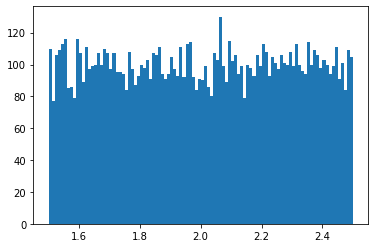

In [10]:
# verify distribution with histogram
plt.hist(V, bins=100);

In [19]:
# generate sample points
lowers = [cost *(mu - 2 * sigma) for cost in C] 
uppers = [cost * (mu + 2 * sigma) for cost in C]


tier_1_prices = np.linspace(lowers[0], uppers[0], num=50)
tier_2_prices = np.linspace(lowers[1], uppers[1], num=50)

print(tier_1_prices)
print(tier_2_prices)

prices_profits = []
profits = []

# compute profit at sample points
for t1_price in tqdm(tier_1_prices):
    for t2_price in tier_2_prices:
        P = [t1_price, t2_price]
        decisions = simulate_decisions_eff(P,C,B, S, V, scaling_lambda, True)
        profit_point = profit(P, C, decisions)
        profits.append(profit_point)
        prices_profits.append([t1_price, t2_price, profit_point])

[1.         1.04081633 1.08163265 1.12244898 1.16326531 1.20408163
 1.24489796 1.28571429 1.32653061 1.36734694 1.40816327 1.44897959
 1.48979592 1.53061224 1.57142857 1.6122449  1.65306122 1.69387755
 1.73469388 1.7755102  1.81632653 1.85714286 1.89795918 1.93877551
 1.97959184 2.02040816 2.06122449 2.10204082 2.14285714 2.18367347
 2.2244898  2.26530612 2.30612245 2.34693878 2.3877551  2.42857143
 2.46938776 2.51020408 2.55102041 2.59183673 2.63265306 2.67346939
 2.71428571 2.75510204 2.79591837 2.83673469 2.87755102 2.91836735
 2.95918367 3.        ]
[ 4.          4.16326531  4.32653061  4.48979592  4.65306122  4.81632653
  4.97959184  5.14285714  5.30612245  5.46938776  5.63265306  5.79591837
  5.95918367  6.12244898  6.28571429  6.44897959  6.6122449   6.7755102
  6.93877551  7.10204082  7.26530612  7.42857143  7.59183673  7.75510204
  7.91836735  8.08163265  8.24489796  8.40816327  8.57142857  8.73469388
  8.89795918  9.06122449  9.2244898   9.3877551   9.55102041  9.71428571
  9

100%|██████████| 50/50 [00:14<00:00,  3.42it/s]


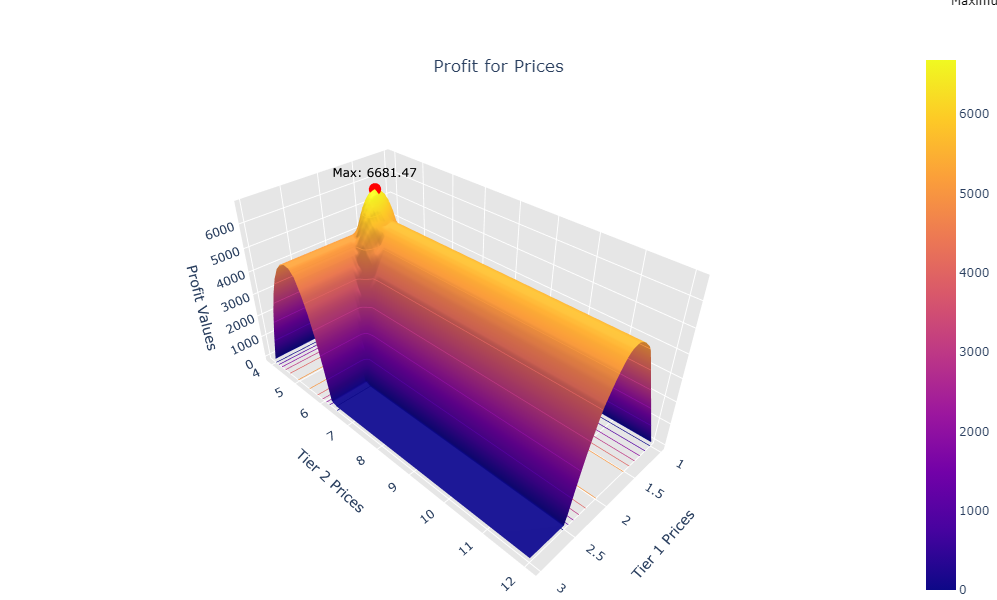

In [20]:
# fig = plt.figure(figsize=(12, 16))
# ax = Axes3D(fig)


prices_prof_arr = np.array(prices_profits)

tier_1_vals = prices_prof_arr[:,0]
tier_2_vals = prices_prof_arr[:,1]
profit_vals = prices_prof_arr[:,2]

X,Y = np.meshgrid(tier_1_prices, tier_2_prices)
Z = profit_vals.reshape(X.shape).T

# Taking log of profit b/c I want to emphasize higher values more
# profit_normalized = (profit_options - np.min(profit_options)) / (np.max(profit_options) - np.min(profit_options))
# profit_log_transformed = np.log1p(profit_normalized * 0.0000001)  

# colors = plt.cm.viridis(profit_log_transformed / np.max(profit_log_transformed))

# ax.plot_surface(X,Y,Z, cmap=plt.cm.viridis, zorder=0)
fig = go.Figure(data=[go.Surface(
    z=Z,
    x=X,
    y=Y,
    colorscale='Plasma',  # Change to a vibrant colormap
    contours={
        "z": {
            "show": True,
            "usecolormap": True,
            "highlightcolor": "lime",
            "project": {"z": True}
        }
    }
)])

maximum = max(profits)
inds = [i for i, x in enumerate(profits) if x == maximum]
tier_1_price = tier_1_vals[inds]
tier_2_price = tier_2_vals[inds]

fig.add_trace(go.Scatter3d(
    x=tier_1_price, y=tier_2_price, z=[maximum],
    mode='markers+text',
    marker=dict(size=7, color='red', symbol='circle'),
    text=[f"Max: {maximum:.2f}"],
    textfont=dict(size=12, color="black"),
    textposition="top center"
))

fig.update_layout(
    title={
        'text': "Profit for Prices",
        'y': 0.9,  # Adjust title position
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(title="Tier 1 Prices", backgroundcolor="rgb(230, 230, 230)", gridcolor="white"),
        yaxis=dict(title="Tier 2 Prices", backgroundcolor="rgb(230, 230, 230)", gridcolor="white"),
        zaxis=dict(title="Profit Values", backgroundcolor="rgb(230, 230, 230)", gridcolor="white"),
        camera=dict(eye=dict(x=1.5,y=1.5, z=1.5)),  # Set camera position for better perspective
        aspectratio=dict(x=1,y=2,z=1)
    ),
    autosize = False,
    width=1200,
    height=600,
    margin=dict(l=0, r=0, t=50, b=0),  # Reduce margins
    coloraxis_colorbar=dict(title="Profit", tickvals=np.linspace(Z.min(), Z.max(), 5))
)

fig.add_annotation(
    x=tier_1_price[0],
    y=tier_2_price[0],
    text="Maximum Point",
    showarrow=True,
    arrowhead=2,
    ax=-40,
    ay=40,
    font=dict(color="black", size=12),
    arrowcolor="red"
)

# Show the plot
fig.show()

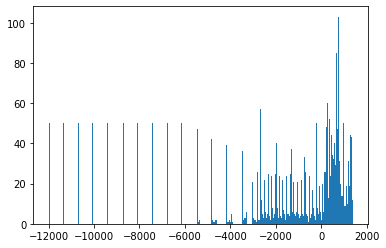

In [67]:
plt.hist(profits, bins=300);

In [68]:
print(maximum)
print(tier_1_price[0])
print(tier_2_price[0])

prices = [tier_1_price[0],tier_2_price[0]]

sample(prices,C,B,S, V, scaling_lambda, True)

print(profits.count(max(profits)))

1390.1224489795977
2.571428571428571
7.673469387755102
number of customers 1000
customers who didn't purchase: 514
customers who chose tier one: 188
customers who chose tier two: 298
customers who chose tier three: 0
profit: 1390.1224489795977
1


In [18]:
# defining params
N = 1000
C = [1,3,5]
B = len(C);
S = 1000000

# define valuation parameters for N customers
mu = 2
sigma = 0.5
lower = 0
upper = mu+sigma*6

V = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
# V = np.random.uniform(mu - sigma, mu + sigma, size=N)
# V = [2,2,2,4]


scaling_lambda = 5
print(scaling_lambda)

5


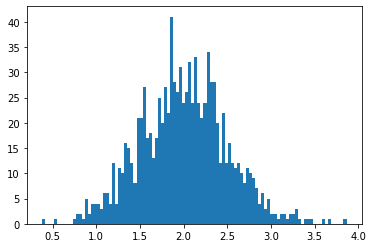

In [19]:
# verify distribution with histogram
plt.hist(V, bins=100);

In [20]:
# generate sample points
lowers = [cost *(mu - 2 * sigma) for cost in C] 
uppers = [cost * (mu + 0.5 * sigma) for cost in C]


tier_1_prices = np.linspace(lowers[0], uppers[0], num=15)
tier_2_prices = np.linspace(lowers[1], uppers[1], num=15)
tier_3_prices = np.linspace(lowers[2],uppers[2], num=15)

print(tier_1_prices)
print(tier_2_prices)
print(tier_3_prices)

prices_profits = []
profits = []

# compute profit at sample points
for t1_price in tqdm(tier_1_prices):
    for t2_price in tier_2_prices:
        for t3_price in tier_3_prices:
            P = [t1_price, t2_price, t3_price]
            decisions = simulate_decisions_eff(P,C,B, S, V, scaling_lambda, diminish=True)
            profit_point = profit(P, C, decisions)
            profits.append(profit_point)
            prices_profits.append([t1_price, t2_price, t3_price, profit_point])

[1.         1.08928571 1.17857143 1.26785714 1.35714286 1.44642857
 1.53571429 1.625      1.71428571 1.80357143 1.89285714 1.98214286
 2.07142857 2.16071429 2.25      ]
[3.         3.26785714 3.53571429 3.80357143 4.07142857 4.33928571
 4.60714286 4.875      5.14285714 5.41071429 5.67857143 5.94642857
 6.21428571 6.48214286 6.75      ]
[ 5.          5.44642857  5.89285714  6.33928571  6.78571429  7.23214286
  7.67857143  8.125       8.57142857  9.01785714  9.46428571  9.91071429
 10.35714286 10.80357143 11.25      ]


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]


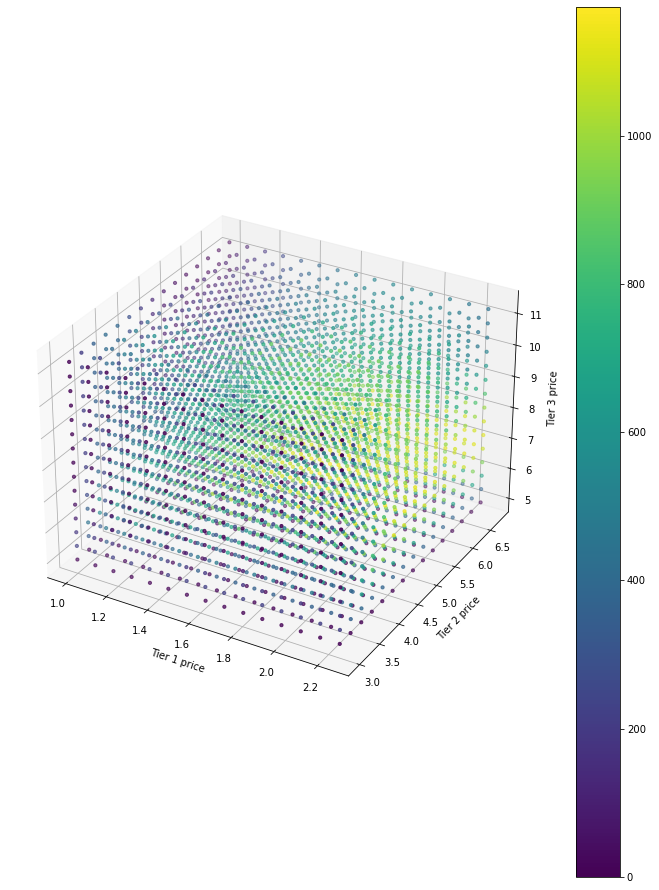

In [21]:
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, projection='3d')


prices_prof_arr = np.array(prices_profits)

tier_1_options = prices_prof_arr[:,0]
tier_2_options = prices_prof_arr[:,1]
tier_3_options = prices_prof_arr[:,2]
profit_vals = prices_prof_arr[:,3]

scat = ax.scatter(tier_1_options, tier_2_options, tier_3_options, c = profit_vals, cmap = plt.cm.viridis, s = 10)
fig.colorbar(scat)

ax.set_xlabel('Tier 1 price')
ax.set_ylabel('Tier 2 price')
ax.set_zlabel('Tier 3 price')


plt.show()

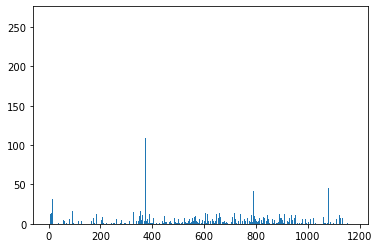

In [22]:
plt.hist(profits, bins=1000);

In [23]:
maximum = max(profits)
inds = [i for i, x in enumerate(profits) if x == maximum]
tier_1_price = tier_1_options[inds]
tier_2_price = tier_2_options[inds]
tier_3_price = tier_3_options[inds]

print(maximum)
print(tier_1_price[0])
print(tier_2_price[0])
print(tier_3_price[0])

prices = [tier_1_price[0], tier_2_price[0], tier_3_price[0]]

sample(prices,C,B,S, V, scaling_lambda, diminish = True)

print(profits.count(max(profits)))

1173.3035714285768
1.8035714285714286
4.607142857142858
7.232142857142858
number of customers 1000
customers who didn't purchase: 336
customers who chose tier one: 158
customers who chose tier two: 133
customers who chose tier three: 373
profit: 1173.3035714285768
1


# Scipy Optimize Approach (Dual Annealing)

In [12]:
def valuation_params(N):
    # define valuation parameters for N customers
    mu = 2
    sigma = 0.5
    lower = 0
    upper = mu+sigma*6

    # V = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
    V = np.random.uniform(mu - sigma, mu + sigma, size=N)
    # V = [2,2,2,4]
    
    return V

In [13]:
def objective(P):
    
    
    global iters
    diminish = True

    decisions = simulate_decisions_eff(P,C,B, S, V, scaling_lambda, diminish)
    profit_point = profit(P, C, decisions)
    iters+=1
    if iters%1000 == 0:
        print (f"{iters}: {P}, {profit_point}")
    return -profit_point


In [14]:
C = [1, 4]
B = len(C)
S = 1000000
N=10000
V = valuation_params(N)
scaling_lambda = 3

In [15]:
p_init = [1.83,6]
iters=0

bounds = [(1,10),(4,20)]
result = scipy.optimize.dual_annealing(objective, bounds)
print(result)
P = result.x
print(P)
sample(P, C, B, S, V, scaling_lambda, True)

1000: [1.8003448  5.27895592], 6679.150411976546
2000: [1.75089461 5.20476652], 6727.426702727598
3000: [ 3.76782907 18.91882122], 0
4000: [1.75036379 5.0803198 ], 6714.8787024725925
5000: [5.04200008 5.15265321], 5254.945981083975
6000: [1.75036963 5.15258709], 6751.481041822346
     fun: -6751.914036825741
 message: ['Maximum number of iteration reached']
    nfev: 6020
    nhev: 0
     nit: 1000
    njev: 673
  status: 0
 success: True
       x: array([1.75036963, 5.15275035])
[1.75036963 5.15275035]
number of customers 10000
customers who didn't purchase: 2424
customers who chose tier one: 4924
customers who chose tier two: 2652
customers who chose tier three: 0
profit: 6751.914007940799


In [28]:
N = 1000
C = [1,3,5]
B = len(C);
S = 1000000
V = valuation_params(N)
scaling_lambda = 5


In [29]:
iters=0

bounds = [(1,3),(3,6),(5,10)]
result = scipy.optimize.dual_annealing(objective, bounds)
print(result)
P = result.x
print(P)
sample(P, C, B, S, V, scaling_lambda, True)

1000: [1.9108673  4.99361314 7.6358831 ], 1149.2524016855712
2000: [1.89774668 4.85030432 7.50052829], 1164.994202335196
3000: [2.12813688 4.76915917 5.28958668], 247.59661140851676
4000: [2.9317837  4.51442936 8.0072014 ], 953.1808868293755
5000: [1.89442888 5.38383729 7.55971371], 1152.2242705760273
6000: [1.89442888 4.85030795 7.56039541], 1169.9633753043254
7000: [1.84416644 4.83887818 8.03889356], 1042.8975964871765
8000: [1.89442888 5.22363968 7.56314163], 1150.1963071350588
     fun: -1170.210628067394
 message: ['Maximum number of iteration reached']
    nfev: 8361
    nhev: 0
     nit: 1000
    njev: 590
  status: 0
 success: True
       x: array([1.89442888, 4.85030794, 7.56314163])
[1.89442888 4.85030794 7.56314163]
number of customers 1000
customers who didn't purchase: 423
customers who chose tier one: 147
customers who chose tier two: 89
customers who chose tier three: 341
profit: 1170.189745996929
